In [1]:
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 7.8 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=8564261c68e8833e14f872b147601c6107d6306ce5ad21a4297cfafe73e9cc49
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 763.5 MB 15 kB/s 
     |████████████████████████████████| 17.3 MB 1.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:


In [2]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# After this step it will ask you to restart the runtime, please do it.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.3 MB 6.1 MB/s 
     |████████████████████████████████| 50 kB 4.0 MB/s 
     |████████████████████████████████| 130 kB 15.5 MB/s 
     |████████████████████████████████| 79 kB 9.1 MB/s 
     |████████████████████████████████| 151 kB 67.5 MB/s 
     |████████████████████████████████| 843 kB 43.9 MB/s 
     |████████████████████████████████| 117 kB 20.1 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=80a59c02674f497671da67eed161559d964af6f79e55fb55b79011baec891fbb
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=8adc3c73facc7de8f43

In [1]:
import torch
assert torch.__version__.startswith("1.8") 
import torchvision
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 224
        record["width"] = 224
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

Mounted at /content/drive


In [3]:
classes = ['bean','cucumber']

data_path = '/content/drive/MyDrive/Colab_Dataset/Vegetables/Labeled/Bean_Cucumber/'

for d in ["train", "test"]:
    DatasetCatalog.register(
        "category_" + d, 
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    MetadataCatalog.get("category_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("category_train")

In [4]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer

In [13]:
output_dir = '/content/drive/MyDrive/Colab_Dataset/Vegetables/Labeled/Bean_Cucumber/'
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("category_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.OUTPUT_DIR = output_dir # unutma output_dir tanımla ki model ve cfg aynı yerde olsun dikkat et!(pickle)

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

In [15]:
trainer.train()

[07/11 11:39:34 d2.engine.train_loop]: Starting training from iteration 0
[07/11 11:39:41 d2.utils.events]:  eta: 1:01:46  iter: 19  total_loss: 2.914  loss_cls: 1.449  loss_box_reg: 0.126  loss_mask: 0.693  loss_rpn_cls: 0.5062  loss_rpn_loc: 0.06068  time: 0.3681  data_time: 0.0157  lr: 4.9953e-06  max_mem: 2853M
[07/11 11:39:49 d2.utils.events]:  eta: 1:01:39  iter: 39  total_loss: 2.622  loss_cls: 1.275  loss_box_reg: 0.1251  loss_mask: 0.6907  loss_rpn_cls: 0.575  loss_rpn_loc: 0.05555  time: 0.3709  data_time: 0.0068  lr: 9.9902e-06  max_mem: 2853M
[07/11 11:39:56 d2.utils.events]:  eta: 1:01:32  iter: 59  total_loss: 2.311  loss_cls: 0.9416  loss_box_reg: 0.151  loss_mask: 0.6852  loss_rpn_cls: 0.384  loss_rpn_loc: 0.04474  time: 0.3710  data_time: 0.0075  lr: 1.4985e-05  max_mem: 2853M
[07/11 11:40:04 d2.utils.events]:  eta: 1:01:21  iter: 79  total_loss: 1.948  loss_cls: 0.6586  loss_box_reg: 0.1502  loss_mask: 0.6797  loss_rpn_cls: 0.3054  loss_rpn_loc: 0.0483  time: 0.3734  

In [16]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.DATASETS.TEST = ("skin_test", )
predictor = DefaultPredictor(cfg)

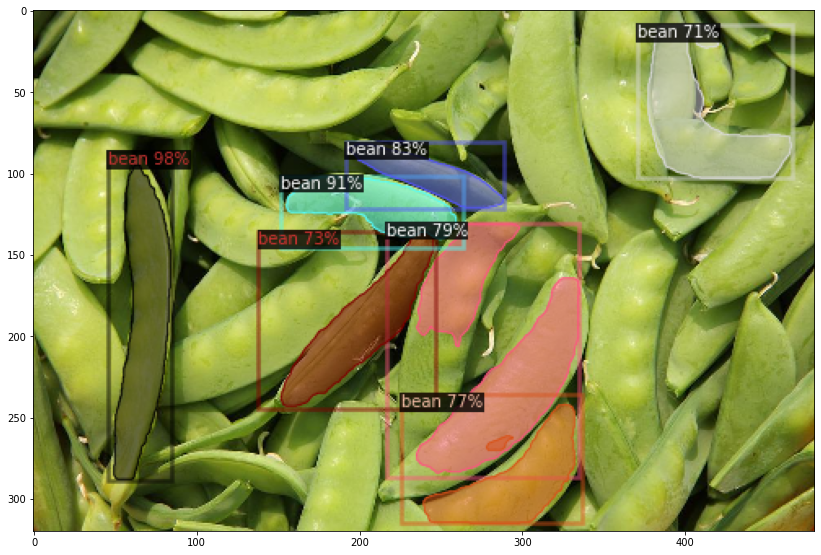

In [17]:
def on_image(image_path,predictor):
    
    im = cv2.imread(image_path)
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1], metadata=microcontroller_metadata ,scale = 0.5,instance_mode=ColorMode.SEGMENTATION)#ColorMode.IMAGE_BW ->Gray
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(14,10))
    plt.imshow(v.get_image())
    plt.show()

image_path = "/content/bean_test_2.jpg"
on_image(image_path, predictor)

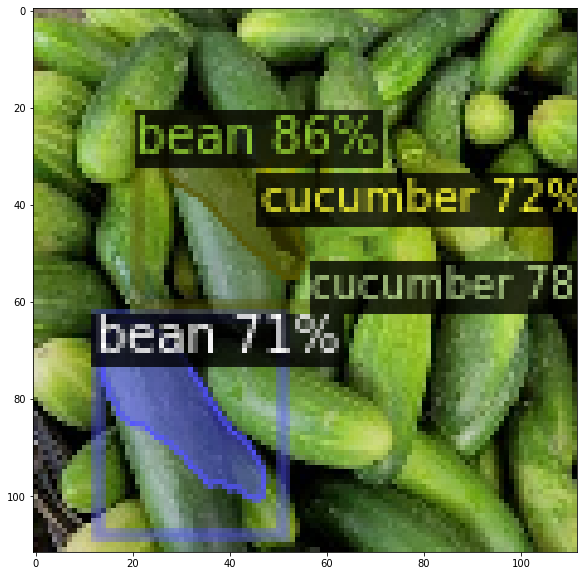

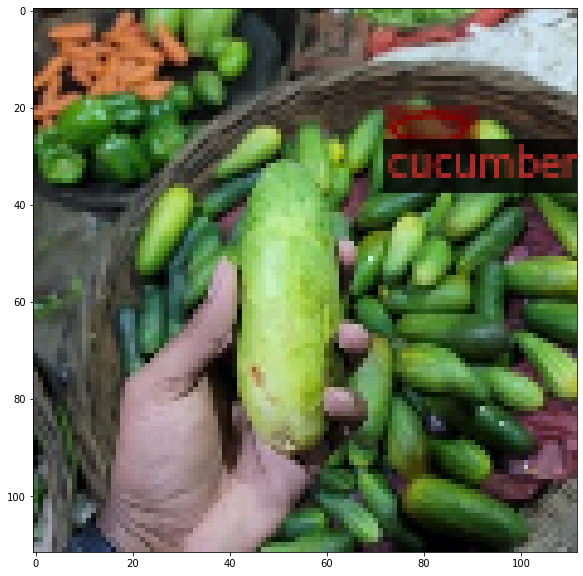

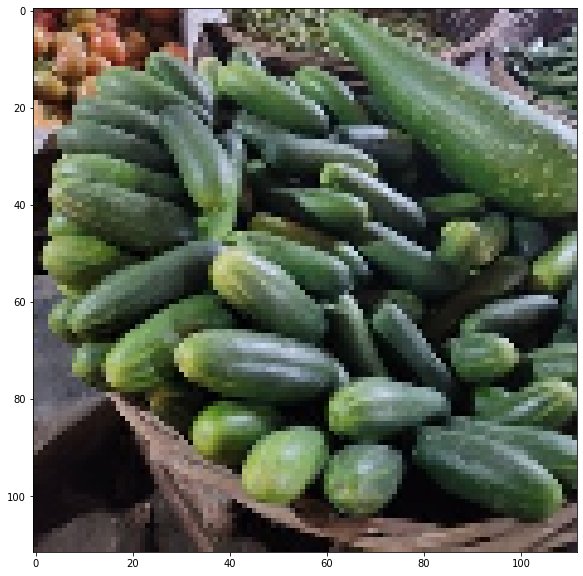

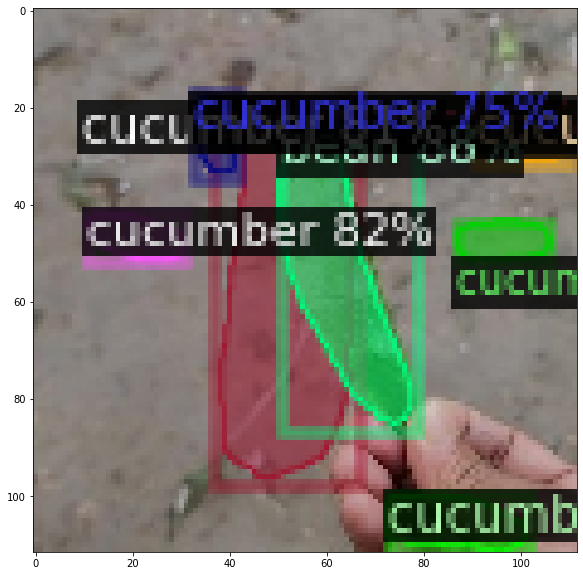

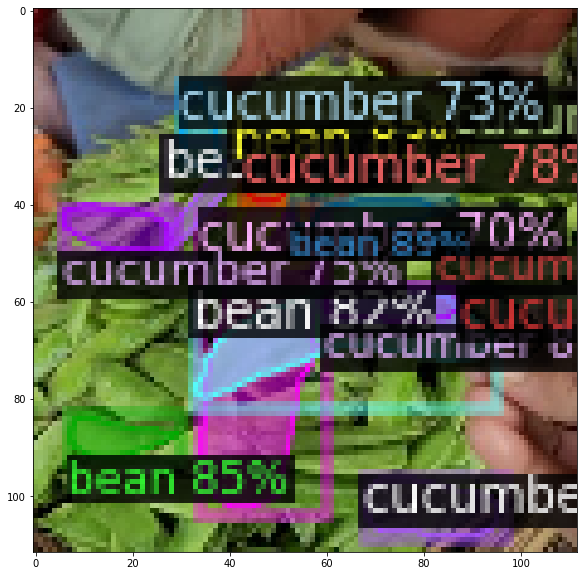

In [18]:
image_path = "/content/c0011.jpg"
on_image(image_path, predictor)

image_path = "/content/c0010.jpg"
on_image(image_path, predictor)

image_path = "/content/c0018.jpg"
on_image(image_path, predictor)

image_path = "/content/0003.jpg"
on_image(image_path, predictor)
image_path = "/content/0002.jpg"
on_image(image_path, predictor)